In [3]:
#Get zipped dataset from https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=True.csv
import zipfile

# Unzip Fake.csv.zip
with zipfile.ZipFile("Fake.csv.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Unzip True.csv.zip
with zipfile.ZipFile("True.csv.zip", 'r') as zip_ref:
    zip_ref.extractall()


In [45]:
import numpy as np
import pandas as pd
import plotly.express as px

from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Embedding,GRU,LSTM,Dense,Input

In [7]:
#Enter the paths of CSV files of real and fake news here
true_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')

In [8]:
true_news.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [9]:
fake_news.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [17]:
# Only including 'title' column in real and fake df's bacause we are going to classigy only on that basis 
#And adding column named 'label' : 0 for true and 1 for fake
fake_news['label'] = 0
true_news['label'] = 1
# Combine and shuffle
news_df = pd.concat([fake_news[['title', 'label']], true_news[['title', 'label']]], ignore_index=True)
news_df = news_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
news_df

,title,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0
1,Trump drops Steve Bannon from National Securit...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,0
4,Donald Trump heads for Scotland to reopen a go...,1
...,...,...
44893,UNREAL! CBS’S TED KOPPEL Tells Sean Hannity He...,0
44894,PM May seeks to ease Japan's Brexit fears duri...,1
44895,Merkel: Difficult German coalition talks can r...,1
44896,Trump Stole An Idea From North Korean Propaga...,0


Now, our data is ready for some proprocessing...

In [65]:
ps = PorterStemmer()
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()


def process_title(title):
    new_title = title.lower() #lower casing 
    new_title = re.sub(r'\$[^\s]+', 'dollar', new_title) # substituting $100 or $ 30 with dollar
    new_title = re.sub(r'[^a-z0-9\s]', '', new_title) # removing punctuation marks
    new_title = re.sub(r'[0-9]+', 'number', new_title) # substituting 0-9 with number
    new_title = new_title.split() # splitting sentences into words
    new_title = list(map(lambda x: ps.stem(x), new_title))  # steming
    new_title = list(map(lambda x: x.strip(), new_title))  # striping
    return new_title

In [66]:
titles = news_df['title'].apply(process_title)
labels = np.array(news_df['label'])

In [67]:
titles

0        [ben, stein, call, out, numberth, circuit, cou...
1        [trump, drop, steve, bannon, from, nation, sec...
2        [puerto, rico, expect, us, to, lift, jone, act...
3        [oop, trump, just, accident, confirm, he, leak...
4        [donald, trump, head, for, scotland, to, reope...
                               ...                        
44893    [unreal, cbss, ted, koppel, tell, sean, hannit...
44894    [pm, may, seek, to, eas, japan, brexit, fear, ...
44895    [merkel, difficult, german, coalit, talk, can,...
44896    [trump, stole, an, idea, from, north, korean, ...
44897    [break, hillari, clinton, state, depart, gave,...
Name: title, Length: 44898, dtype: object

In [148]:
import pickle
# Save titles to a file
with open('titles.pkl', 'wb') as f:
    pickle.dump(titles, f)


In [68]:
# Get size of vocabulary
vocabulary = set()

for title in titles:
    for word in title:
        if word not in vocabulary:
            vocabulary.add(word)

vocab_length = len(vocabulary)

# Get max length of a sequence
max_seq_length = 0

for title in titles:
    if len(title) > max_seq_length:
        max_seq_length = len(title)

# Print results
print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

  

Vocab length: 17785
Max sequence length: 42


In [69]:
# Now, tokeznizing and apply padding
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(titles)

sequences = tokenizer.texts_to_sequences(titles)

word_index = tokenizer.word_index

padded_inputs = pad_sequences(sequences, maxlen=max_seq_length)

In [70]:
padded_inputs

array([[   0,    0,    0, ...,   61,    8, 1226],
       [   0,    0,    0, ...,  148,  133,  962],
       [   0,    0,    0, ...,  429, 1718, 1559],
       ...,
       [   0,    0,    0, ...,  931,   10,   94],
       [   0,    0,    0, ...,  842,  329,  274],
       [   0,    0,    0, ...,    1, 2587, 1050]])

In [71]:
padded_inputs.shape  # 44898 titles and each title(sequence) has 42 words (padded)

(44898, 42)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(padded_inputs, labels)

Its time to build model ...

In [84]:
embedding_dim = 64

inputs = Input(shape=(max_seq_length,))
embedding = Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)

gru = GRU(units=embedding_dim)(embedding)
outputs = Dense(1, activation='sigmoid')(gru)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy'
    ]
)

In [98]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 42, 64)         │     1,138,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,489,797 (13.31 MB)

 Trainable params: 1,163,265 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,326,532 (8.88 MB)

In [86]:
batch_size = 32
epochs = 3

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)
    ]

)

Epoch 1/3
842/842 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9801 - loss: 0.0559

842/842 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - accuracy: 0.9801 - loss: 0.0558 - val_accuracy: 0.9608 - val_loss: 0.1069 - learning_rate: 0.0010
Epoch 2/3
842/842 ━━━━━━━━━━━━━━━━━━━━ 55s 65ms/step - accuracy: 0.9929 - loss: 0.0221 - val_accuracy: 0.9639 - val_loss: 0.1245 - learning_rate: 0.0010
Epoch 3/3
842/842 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - accuracy: 0.9962 - loss: 0.0116 - val_accuracy: 0.9602 - val_loss: 0.1501 - learning_rate: 0.0010


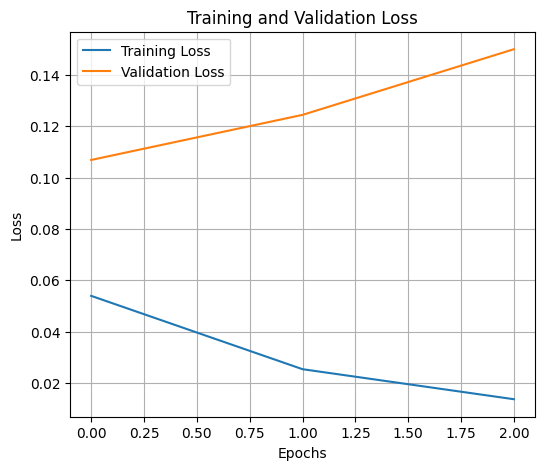

In [89]:
import matplotlib.pyplot as plt

def plot_loss_graph(history):
    """
    Plot training and validation loss from the model's training history.
    """
    # Extract loss and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the losses
    plt.figure(figsize=(6,5))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Pass the history object from model.fit
plot_loss_graph(history)


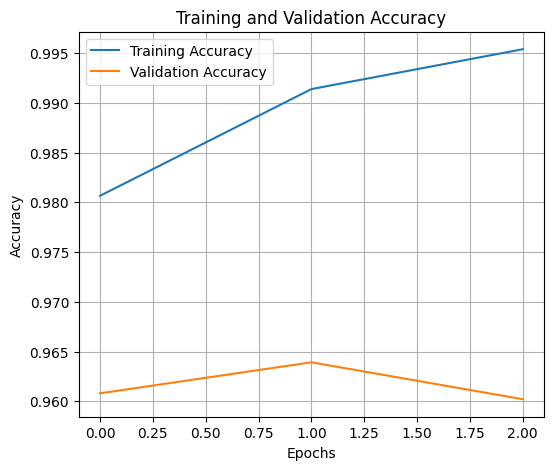

In [90]:
import matplotlib.pyplot as plt

def plot_accuracy_graph(history):
    """
    Plot training and validation accuracy from the model's training history.
    """
    # Extract accuracy and validation accuracy
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot the accuracies
    plt.figure(figsize=(6,5))
    plt.plot(train_accuracy, label="Training Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Pass the history object from model.fit
plot_accuracy_graph(history)


In [91]:
model.load_weights('./model.h5')

In [92]:
model.evaluate(X_test, y_test)

351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9570 - loss: 0.1103


[0.10693538933992386, 0.9604454636573792]

In [140]:

def model_prediction(text):
    text=str(text)
    text=[text]
    text = [process_title(t) for t in text]
    tokenizer.fit_on_texts(titles)
    sequenc = tokenizer.texts_to_sequences(text)
    padded_in=pad_sequences(sequenc, maxlen=max_seq_length)
    prediction = model.predict(padded_in)
    threshold = 0.5  # Decision boundary
    
    # Check the prediction and print the appropriate result
    if prediction[0][0] >= threshold:
        result = "🟩 Real News"
    else:
        result = "🟥 Fake News"
    
    
    # Return the result as well
    return print(result)

In [147]:
model_prediction("Trump is American president")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
🟩 Real News
